In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\ntorchvision: {torchvision.__version__}")

PyTorch version: 2.1.1
torchvision: 0.16.1


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
train_data= torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


100%|██████████| 26421880/26421880 [00:18<00:00, 1426004.80it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 151418.64it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 523788.05it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3197434.77it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

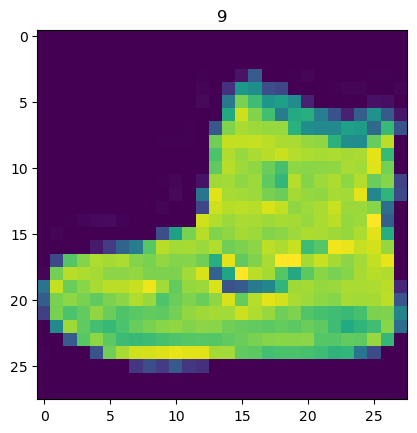

In [6]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")

plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

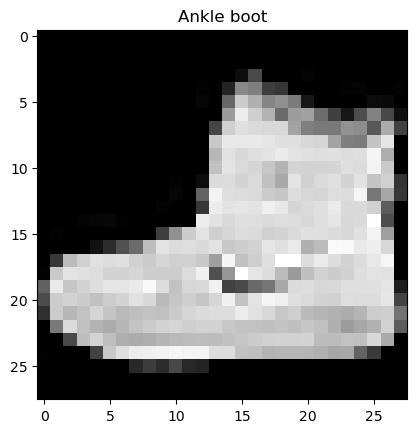

In [7]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

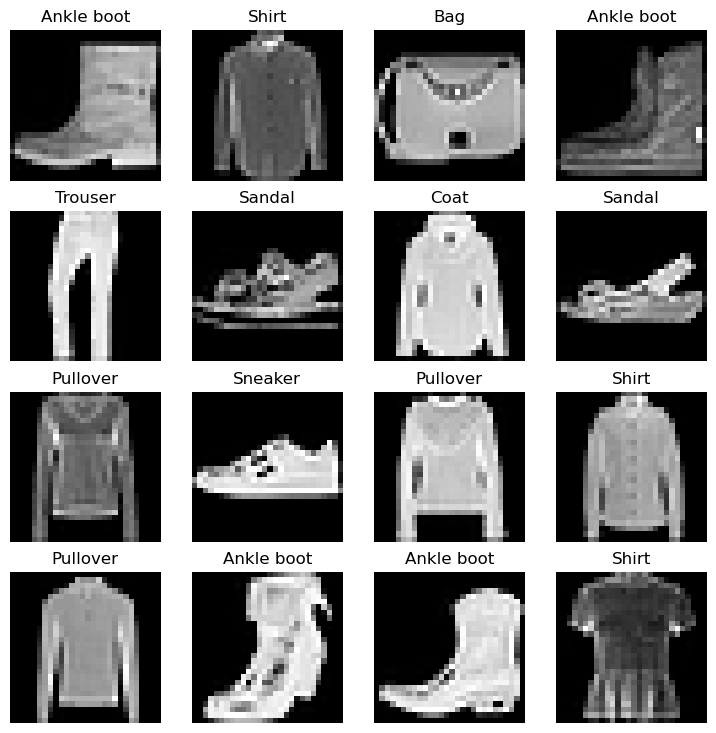

In [8]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
    

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataloders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloders: (<torch.utils.data.dataloader.DataLoader object at 0x78642c4e7150>, <torch.utils.data.dataloader.DataLoader object at 0x78642c07b390>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


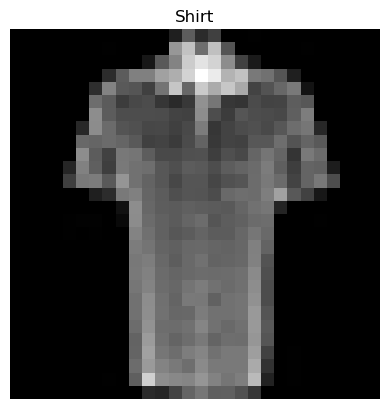

In [11]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch),size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")


In [12]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units:int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)




In [13]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784,hidden_units=10,output_shape=len(class_names))

model_0.to(device)

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [14]:
import math


def output_shape(input_shape, stride, padding, kernal_size):
    return (1+math.floor((input_shape[0] + padding - kernal_size[0])/stride),
            1+math.floor((input_shape[1] + padding - kernal_size[1])/stride))


output_shape((5, 5), 2, 2, (3, 3))

(3, 3)

In [15]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


helper_functions.py already exists, skipping download


In [16]:
from torchmetrics import Accuracy

accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [17]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float,device: torch.device):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [18]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")

    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(
                f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

        train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_0.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

        test_loss /= len(test_dataloader)

        test_acc /= len(test_dataloader)

    print(
        f"\n Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=next(model_0.parameters()).device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

 Train loss: 0.00025 | Test loss: 0.51016, Test acc: 0.82%

Epoch: 1
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

 Train loss: 0.00019 | Test loss: 0.52677, Test acc: 0.82%

Epoch: 2
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

 Train loss: 0.00036 | Test loss: 0.51264, Test acc: 0.83%

Train time on cpu: 23.192 seconds


In [50]:
torch.manual_seed(42)


def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y=X.to(device), y.to(device)
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__,
        "model_loss": loss.item(),
        "model_acc": acc
    }


model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_0_results

{'model_name': __main__.FashionMNISTModelV0,
 'model_loss': 0.5119838714599609,
 'model_acc': 83.02715654952077}

### Fashion MNIST Model with some non-linearity

In [20]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [21]:
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(input_shape=784,
hidden_units=10,
output_shape=len(class_names)).to(device)

next(model_1.parameters()).device

device(type='cpu')

In [22]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [23]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device
               ):
    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device
              ):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [24]:
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")
    train_step(data_loader=train_dataloader,
               model=model_1,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn
               )
    test_step(data_loader=test_dataloader,
              model=model_1,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn
              )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Train loss: 1.05878 | Train accuracy: 62.19%
Test loss: 0.99613 | Test accuracy: 64.09%

Epoch: 1
----
Train loss: 0.91179 | Train accuracy: 66.32%
Test loss: 0.95756 | Test accuracy: 65.47%

Epoch: 2
----
Train loss: 0.88172 | Train accuracy: 67.25%
Test loss: 0.89043 | Test accuracy: 67.08%

Train time on cpu: 27.723 seconds


In [25]:
torch.manual_seed(42)

model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

{'model_name': __main__.FashionMNISTModelV1,
 'model_loss': 0.8907850980758667,
 'model_acc': 67.06269968051119}

In [26]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
            stride=2)

        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)

        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,hidden_units=10,output_shape=len(class_names)).to(device)
model_2


FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [35]:
sp1 = output_shape((28, 28), 1, 1, (3, 3))
print(sp1)
sp2 = output_shape(sp1, 1, 1, (3, 3))
print(sp2)
sp3 = output_shape(sp2, 2, 0, (2, 2))
print(sp3)
sp4 = output_shape(sp3, 1, 1, (3, 3))
print(sp4)
sp5 = output_shape(sp4, 1, 1, (3, 3))
print(sp5)
sp6 = output_shape(sp5, 2, 0, (2, 2))
print(sp6)


(27, 27)
(26, 26)
(13, 13)
(12, 12)
(11, 11)
(5, 5)


In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)


In [37]:
torch.manual_seed(42)

from timeit import default_timer as Timer
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    train_step(data_loader=train_dataloader,
               model=model_2,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(data_loader=test_dataloader,
              model=model_2,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_2 = timer()

total_train_time_model_2 = print_train_time(start=train_time_start_model_2,end=train_time_end_model_2,device=device)
total_train_time_model_2

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.58769 | Train accuracy: 78.64%
Test loss: 0.39929 | Test accuracy: 85.79%

Epoch: 1
------
Train loss: 0.36000 | Train accuracy: 87.00%
Test loss: 0.38717 | Test accuracy: 86.18%

Epoch: 2
------
Train loss: 0.32336 | Train accuracy: 88.28%
Test loss: 0.33121 | Test accuracy: 88.08%

Train time on cpu: 78.025 seconds


78.02502774000459

In [38]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': __main__.FashionMNISTModelV2,
 'model_loss': 0.3305976688861847,
 'model_acc': 88.09904153354633}

In [51]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,<class '__main__.FashionMNISTModelV0'>,0.511984,83.027157
1,<class '__main__.FashionMNISTModelV1'>,0.890785,67.062700
2,<class '__main__.FashionMNISTModelV2'>,0.330598,88.099042


In [52]:
# compare results
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,<class '__main__.FashionMNISTModelV0'>,0.511984,83.027157,23.191689
1,<class '__main__.FashionMNISTModelV1'>,0.890785,67.062700,27.722903
2,<class '__main__.FashionMNISTModelV2'>,0.330598,88.099042,78.025028


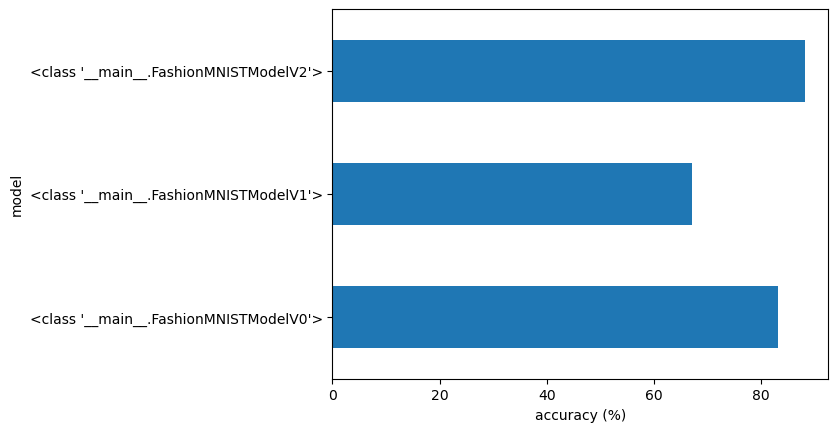

In [53]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [54]:
def make_predictions(model: torch.nn.Module, data: list,device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    
    return torch.stack(pred_probs)

In [55]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [56]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[6.8754e-07, 2.5252e-07, 1.0739e-07, 1.2579e-07, 2.1491e-08, 9.9561e-01,
         1.1291e-07, 5.9172e-04, 9.0814e-05, 3.7026e-03],
        [1.7323e-02, 8.9271e-01, 3.3837e-04, 7.2929e-02, 1.0498e-02, 9.5783e-06,
         5.5765e-03, 3.0200e-04, 2.4599e-04, 6.7111e-05]])

In [57]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 6, 4, 7, 1])